# Probability Calibration

1. When performing the classification task, we often not only to predict the class label but also to **obatin the probability of respective label.**
2. This probability give some sense of confidence about the prediction that model make on the input.
3. But some model will give the poor estimate of the probability and some **don't have the predict_proba** method itself.
4. In such case we need to calibrate the probability or add support for predict_proba.

# Calibration Curve

In [1]:
import numpy as np
from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    def fit(self, X, y, sample_weight=None):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, a_min=0, a_max=1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba


In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=100_000,
                           n_features=20, n_informative=2, n_repeated=2,
                           n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.99,random_state=42)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibrationDisplay

lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier()

clf_list = [("Logistic Regression", lr),
            ("Naive Bayes", gnb),
            ("SVC", svc),
            ("Random Forest", rfc)]

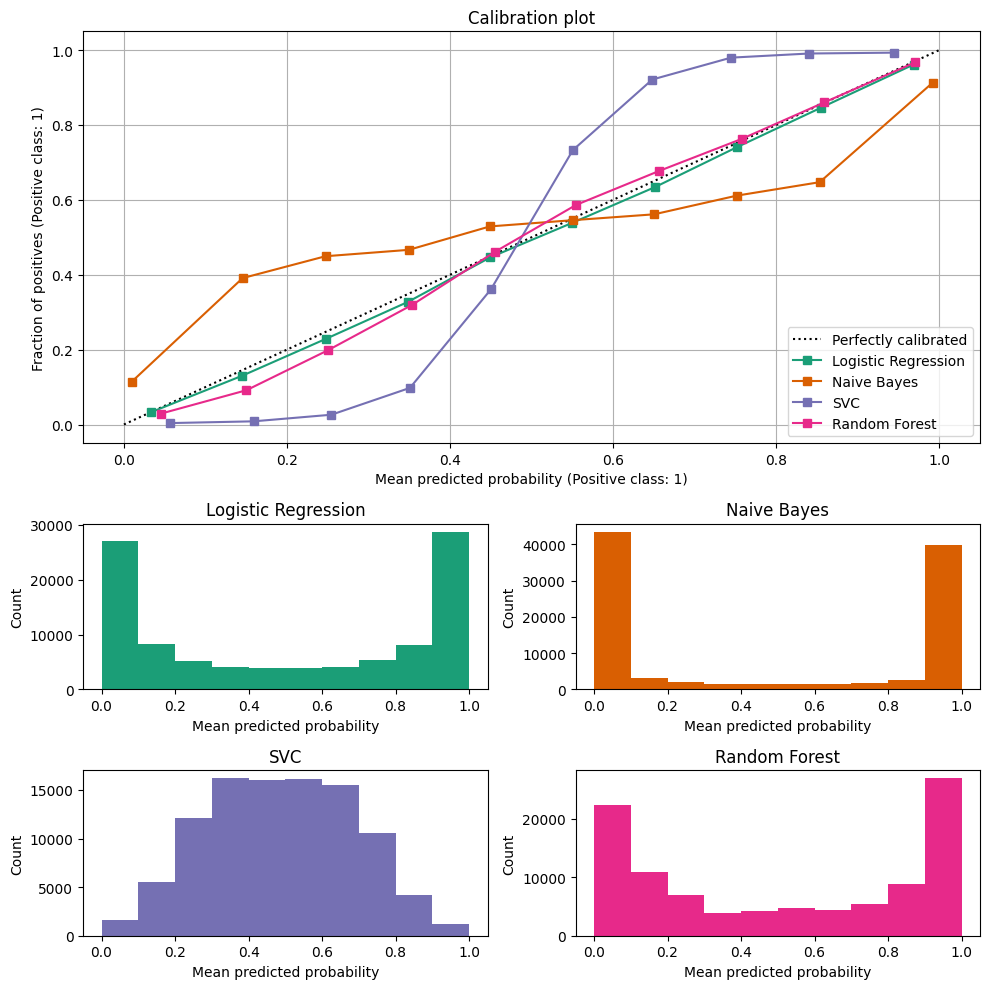

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=4, ncols=2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (name, clf) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(estimator=clf,
                                                X=X_test, y=y_test,
                                                n_bins=10, name=name,
                                                ax=ax_calibration_curve,
                                                color=colors(i))
    calibration_displays[name] = display
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plot")

grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (name, _) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

# Compare the Logistic and Gaussian.

Logistic is often used as the baseline since it use the log-loss as objective function.


In [5]:
from sklearn.calibration import CalibratedClassifierCV

clf_list = [("Logistic Regression", LogisticRegression()),
            ("Naive Bayes", GaussianNB()),
            ("NB + Isotonic", CalibratedClassifierCV(estimator=GaussianNB(),
                                                     cv=2, ensemble=True, method="isotonic")),
            ("NB + Sigmoid", CalibratedClassifierCV(estimator=GaussianNB(),
                                                    cv=2, ensemble=True, method="sigmoid"))]

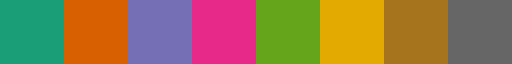

In [6]:
plt.cm._gen_cmap_registry()["Dark2"]

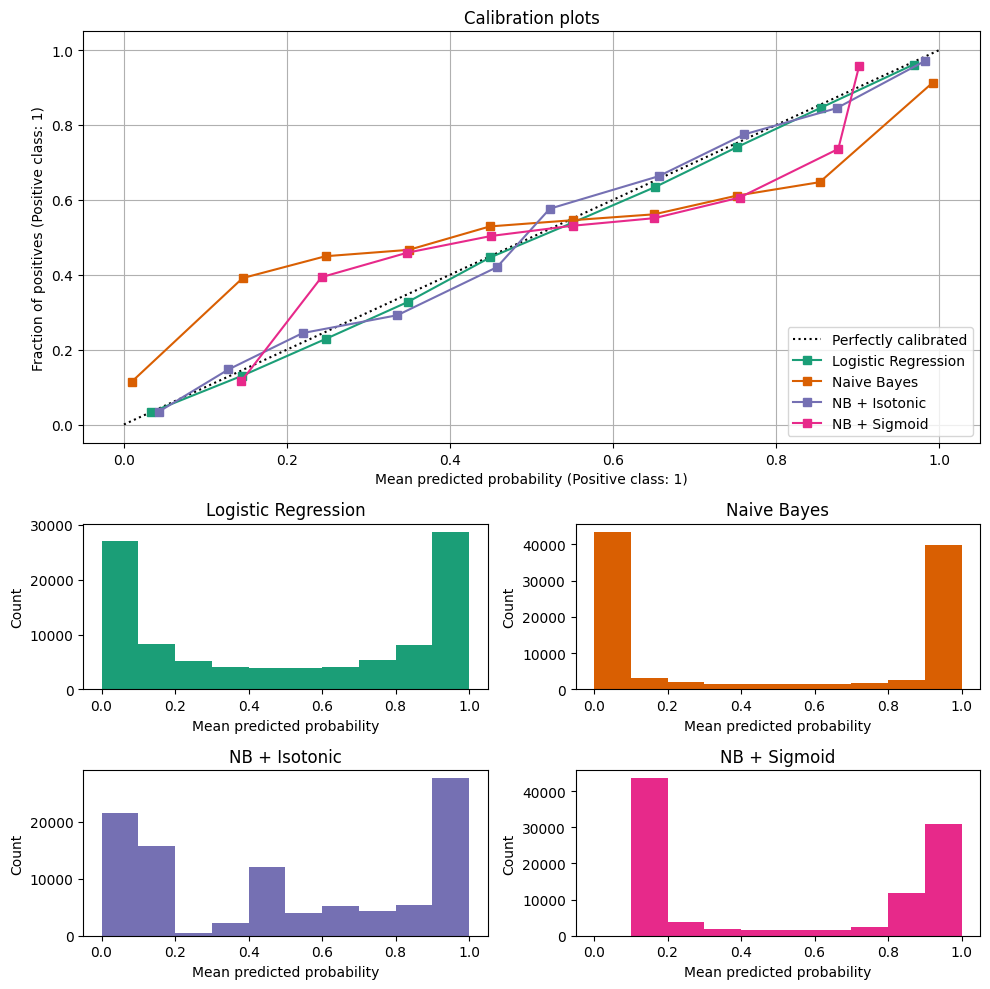

In [7]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=4, ncols=2)
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
colors = plt.cm.get_cmap("Dark2")
calibration_displays = {}

for i, (name, clf) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        estimator=clf,
        X=X_test, y=y_test,
        name=name, n_bins=10,
        ax=ax_calibration_curve,
        color=colors(i)
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

grid_positions = np.array(np.meshgrid(np.arange(2,4),
                                      np.arange(0,2))).T.reshape(-1,2)
for i, (name,_) in enumerate(clf_list):
    row,col= grid_positions[i]
    ax = fig.add_subplot(gs[row,col])
    ax.hist(
        calibration_displays[name].y_prob,
        range=(0,1),
        bins=10,
        label=name,
        color=colors(i)
    )
    ax.set(title=name,xlabel="Mean predicted probability",ylabel="Count")

plt.tight_layout()
plt.show()

1. Uncalibrated GaussianNB is poorly calibrated` because of the redundant features which violate the assumption of feature-independence` and result in an overly confident classifier, which is indicated by the typical transposed-sigmoid curve.
2. Calibration of the probabilities of GaussianNB with Isotonic regression can fix this issue as can be seen from the nearly diagonal calibration curve.
3. Sigmoid regression also improves calibration slightly, albeit not as strongly as the non-parametric isotonic regression. This can be attributed to the fact that we have plenty of calibration data such that the greater flexibility of the non-parametric model can be exploited

In [8]:
from collections import defaultdict
from sklearn.metrics import \
    (precision_score,
     recall_score,
     roc_auc_score,
     brier_score_loss,
     log_loss,
     f1_score)

scores = defaultdict(list)
for i,(name,clf) in enumerate(clf_list):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))


In [9]:
import pandas as pd
pd.DataFrame.from_dict(scores).set_index("Classifier")

,Brier loss,Log loss,Precision,Recall,F1,Roc auc
Classifier,,,,,,
Logistic Regression,0.097332,0.316906,0.858843,0.873333,0.866028,0.864921
Naive Bayes,0.123893,0.566306,0.864405,0.826295,0.844921,0.848360
NB + Isotonic,0.107509,0.402334,0.867866,0.819486,0.842983,0.847379
NB + Sigmoid,0.116395,0.385223,0.858782,0.834680,0.846560,0.848735


4. Notice that although `calibration improves the Brier score loss and Log loss`,
5.  it does not significantly alter the prediction accuracy measures (precision, recall and F1 score). This is because calibration should `not significantly change prediction probabilities at the location of the decision threshold` (at x = 0.5 on the graph). Calibration should however, make the predicted probabilities more accurate and thus more useful for making allocation decisions under uncertainty
6. Further, ROC AUC, `should not change at all because calibration is a monotonic transformation`. Indeed, no rank metrics are affected by calibration.

# Compare the Logistic and SVC

In [10]:
lr = LogisticRegression(C=1.0)
svc = NaivelyCalibratedLinearSVC(max_iter=10_000)
svc_isotonic = CalibratedClassifierCV(svc, cv=2, method="isotonic")
svc_sigmoid = CalibratedClassifierCV(svc, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (svc, "SVC"),
    (svc_isotonic, "SVC + Isotonic"),
    (svc_sigmoid, "SVC + Sigmoid"),
]

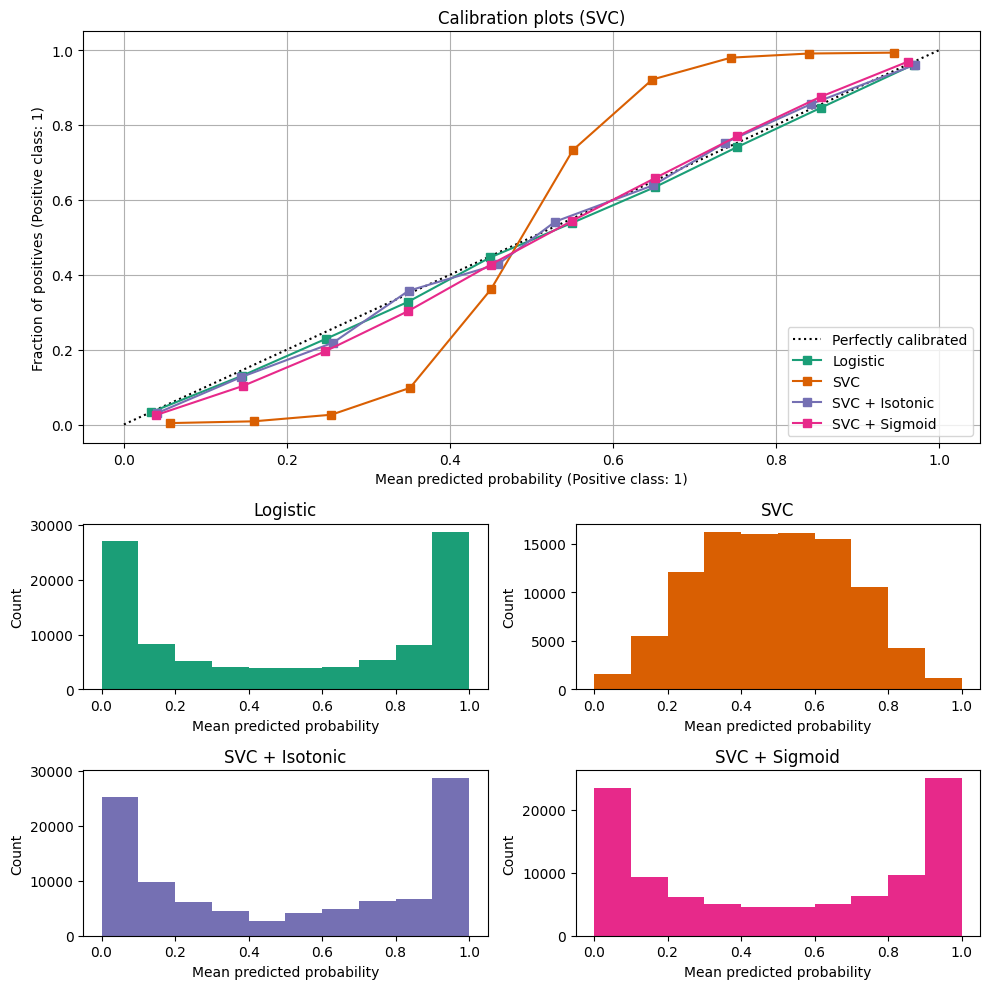

In [11]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (SVC)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

1. LinearSVC shows the opposite behavior to GaussianNB; the calibration curve has a sigmoid shape, which is typical for an `under-confident classifier`.
2. In the case of LinearSVC, this is caused by the margin property of the hinge loss, which focuses on samples that are close to the decision boundary (support vectors). Samples that are far away from the decision boundary do not impact the hinge loss.
3. It thus makes sense that LinearSVC does not try to separate samples in the high confidence region regions.
4. This leads to flatter calibration curves near 0 and 1 and is empirically

In [12]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Precision,Recall,F1,Roc auc
Classifier,,,,,,
Logistic,0.097332,0.316906,0.858843,0.873333,0.866028,0.864921
SVC,0.142757,0.460217,0.858364,0.874303,0.866260,0.865042
SVC + Isotonic,0.098559,0.339487,0.855709,0.876647,0.866051,0.864436
SVC + Sigmoid,0.098379,0.320157,0.857653,0.873838,0.865670,0.864426
